In [2]:
import sys
import os

import sys
sys.path.insert(1, "/home/vakula/vakula/cs231n/sam2_repo")

In [3]:
import glob
import cv2
import torch
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )


using device: cuda


In [5]:
print("Notebook working directory:", os.getcwd())

Notebook working directory: /home/vakula/vakula/cs231n/scripts


In [6]:
sam2_checkpoint = "../sam2_repo/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)
print("Loaded SAM 2.1 model")

Loaded SAM 2.1 model


In [8]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


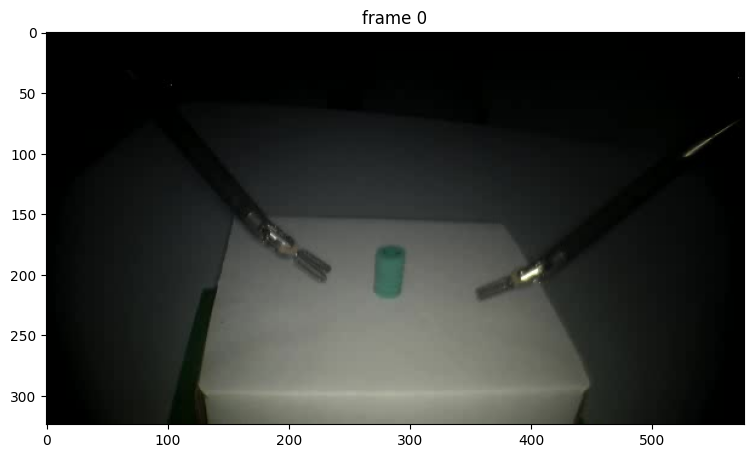

In [9]:
video_dir = "../media/left1_images"

frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [10]:
torch.cuda.empty_cache()

inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

ann_frame_idx = 0 
ann_obj_id = 1 

frame loading (JPEG): 100%|██████████| 451/451 [00:11<00:00, 39.06it/s]


In [11]:
%matplotlib qt

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/vakula/miniconda3/envs/cs231nfp/lib/python3.10/site-packages/cv2/qt/plugins"


In [12]:
coords = []

def onclick(event):
    print(f"CLICK at ({event.xdata}, {event.ydata}) with button {event.button}")
    if event.xdata is not None and event.ydata is not None:
        coords.append((event.xdata, event.ydata))
        plt.scatter(event.xdata, event.ydata, color='red')
        plt.draw()
        if len(coords) >= 3:
            plt.close()

fig, ax = plt.subplots()
ax.imshow(np.ones((300, 300, 3)))  # White image
fig.canvas.mpl_connect('button_press_event', onclick)
plt.title("Click 3 times inside the image")
plt.show()

print("Final clicks:", coords)

Final clicks: []


CLICK at (227.42207792207796, 125.63636363636365) with button 1
CLICK at (50.47402597402599, 67.19480519480521) with button 1
CLICK at (49.66233766233766, 67.19480519480521) with button 1


In [13]:
def get_clicks_from_user(image, max_clicks=5, use_negative_clicks=True):
    import matplotlib.pyplot as plt

    click_coords = []
    click_labels = []
    done = [False]  # wrap in list to make it mutable

    def onclick(event):
        if event.xdata is not None and event.ydata is not None:
            x, y = int(event.xdata), int(event.ydata)
            if use_negative_clicks and event.button == 3:
                label = 0
                color = 'red'
                print(f"Negative click at ({x}, {y})")
            else:
                label = 1
                color = 'green'
                print(f"Positive click at ({x}, {y})")
            click_coords.append([x, y])
            click_labels.append(label)
            ax.scatter(x, y, color=color, marker='*', s=100, edgecolor='white')
            fig.canvas.draw()

            if len(click_coords) >= max_clicks:
                done[0] = True
                plt.close()

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.imshow(image)
    ax.set_title(f"Click to segment (max {max_clicks} clicks)")
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

    # BLOCK until clicks are done
    while not done[0]:
        plt.pause(0.1)

    fig.canvas.mpl_disconnect(cid)

    print("Final clicks:", click_coords)
    return np.array(click_coords, dtype=np.float32), np.array(click_labels, dtype=np.int32)


In [14]:
frame_path = os.path.join(video_dir, frame_names[ann_frame_idx])
image = Image.open(frame_path)

points, labels = get_clicks_from_user(image, max_clicks=5, use_negative_clicks=True)

Positive click at (281, 187)
Positive click at (286, 206)
Positive click at (281, 215)
Positive click at (292, 192)
Positive click at (277, 201)
Final clicks: [[281, 187], [286, 206], [281, 215], [292, 192], [277, 201]]


In [15]:
print("Points:", points)

Points: [[281. 187.]
 [286. 206.]
 [281. 215.]
 [292. 192.]
 [277. 201.]]


In [16]:
 
if points.shape[0] == 0:
    print("No clicks were registered — skipping segmentation.")
else:
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
        clear_old_points=True,
    )


    # Show results
    plt.figure(figsize=(9, 6))
    plt.imshow(image)
    show_points(points, labels, plt.gca())
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
    plt.title("SAM2 Segmentation Result")
    plt.axis("off")
    plt.show()

In [17]:
video_segments = {} 
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

propagate in video: 100%|██████████| 451/451 [14:16<00:00,  1.90s/it]


In [18]:
from PIL import Image

save_dir = "../outputs/rendered_frames2_obj"
os.makedirs(save_dir, exist_ok=True)

for frame_idx in sorted(video_segments.keys()):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis("off")

    # Load and show frame
    image = Image.open(os.path.join(video_dir, frame_names[frame_idx]))
    ax.imshow(image)

    # Overlay masks
    for obj_id, mask in video_segments[frame_idx].items():
        show_mask(mask, ax, obj_id=obj_id)

    # Save figure as image
    fig.savefig(os.path.join(save_dir, f"frame_{frame_idx:04d}.png"), bbox_inches='tight', pad_inches=0)
    plt.close(fig)


In [19]:
import imageio
import glob

output_video_path = "../outputs/vid_op2_objseg.mp4"
fps = 30

frame_paths = sorted(glob.glob(os.path.join(save_dir, "frame_*.png")))

with imageio.get_writer(output_video_path, fps=fps, codec='libx264') as writer:
    for frame_path in frame_paths:
        frame = imageio.imread(frame_path)
        writer.append_data(frame)

print(f"🎉 Video saved to: {output_video_path}")


/tmp/ipykernel_38396/2152052599.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(frame_path)


🎉 Video saved to: ../outputs/vid_op2_objseg.mp4


In [2]:
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

frame_path = os.path.join(video_dir, frame_names[200])
image = Image.open(frame_path)

points, labels = get_clicks_from_user(image, max_clicks=5, use_negative_clicks=True)

NameError: name 'predictor' is not defined

In [ ]:
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=200,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
        clear_old_points=True,
    )


    # Show results
plt.figure(figsize=(9, 6))
plt.imshow(image)
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
plt.title("Object Segmentation Result: Frame 300")
plt.axis("off")
plt.show()